# **Лабораторная работа 4**

Аксаева Дарья Александровна, БИВТ-20-1

#cats_vs_dogs

Датасет "cats_vs_dogs" содержит фотографии, каждая из которых подписана как "кошка" или "собака". Этот датасет необходим для обучения компьютерных моделей, чтобы они могли научиться различать кошек и собак на фотографиях и автоматически их распознавать. Данный датасет содержит в себе 2 класса и 10000 изображений.

# Подключение библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from google.colab import files

# Использование GPU

Это нужно для более быстрого обучения модели.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Скачивание и распаковка датасета с веб-сайта Kaggle

In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dhirensk/cats-vs-dogs-training8000test2000
!unzip cats-vs-dogs-training8000test2000.zip

# Пути к директориям

In [ ]:
path_to_dataset = './dataset/dataset'
path_to_train_dataset = './dataset/dataset/training_set'
path_to_test_dataset = './dataset/dataset/test_set'

# Длина и ширина изображений для нормализации

In [ ]:
width = 150
height = width

# Создание тестового и тренировочного датасетов, с помощью библиотеки torch и нормализация изображений

In [ ]:
data_transform = transforms.Compose([transforms.Resize((width, height)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(root=path_to_train_dataset, transform=data_transform)
test_data = datasets.ImageFolder(root=path_to_test_dataset, transform=data_transform)

# Информация о моем датасете

In [ ]:
print(f"Датасет состоит из {len(train_data) + len(test_data)} изображений")
print("Классы:")
print(train_data.classes)
num_class = len(train_data.classes)
print("Количество классов:")
print(num_class)

Датасет состоит из 10000 изображений
Классы:
['cats', 'dogs']
Количество классов:
2


# Разделение датасета на батчи

In [ ]:
batch_size = 128

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Вывод изображений из датасета

Данный код выводит по 5 случайных изображений из train_dataset и test_dataset

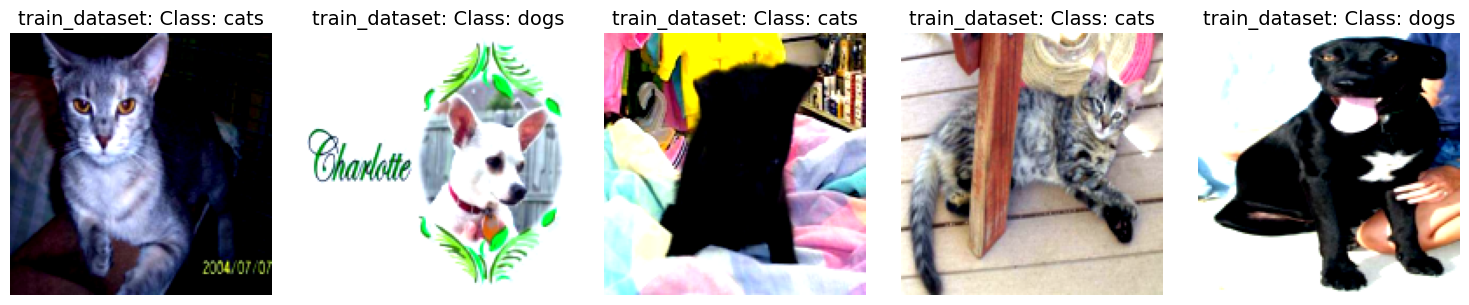

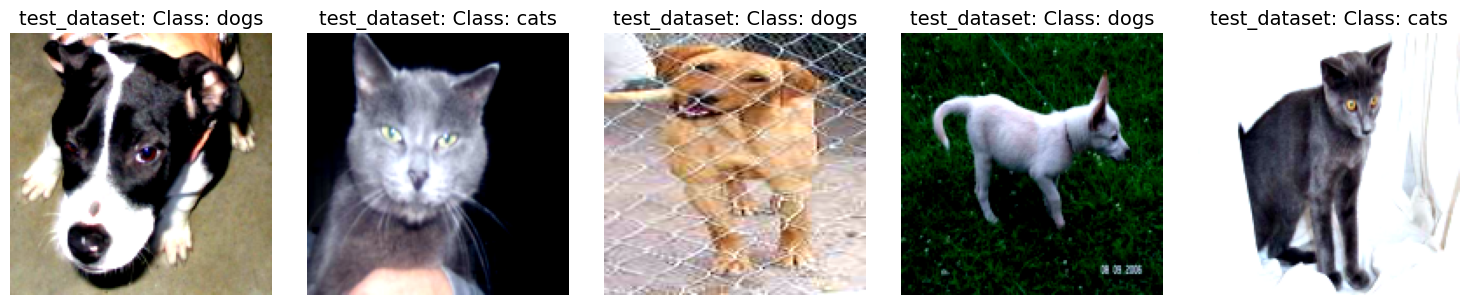

In [ ]:
def show_images(dataset, num_examples=5):
    class_indices = dataset.class_to_idx
    class_names = list(class_indices.keys())
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    fig.patch.set_visible(False)
    for ax in axes:
        ax.axis('off')
    for i, ax in enumerate(axes):
        if dataset == train_data:
            dataset_name = "train_dataset"
        elif dataset == test_data:
            dataset_name = "test_dataset"
        class_name = np.random.choice(class_names)
        class_index = class_indices[class_name]
        image_index = np.random.randint(len(dataset.targets))
        while dataset.targets[image_index] != class_index:
            image_index = np.random.randint(len(dataset.targets))
        image, label = dataset[image_index]
        image = np.clip(image.permute(1, 2, 0).numpy() * 0.4 + 0.4, 0, 1)
        ax.imshow(image)
        ax.set_title(f"{dataset_name}: Class: {class_name}", fontsize=14)

    plt.tight_layout()
    plt.show()

show_images(train_data)
show_images(test_data)


# Структура нейросети

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.activation = nn.Sigmoid()
        self.fc1 = nn.Linear(3 * width * height, 128)
        self.fc2 = nn.Linear(128, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Функции для обучения моделей и получения их точности

In [ ]:
def train_model(model, train_data_loader, criterion, optimization, num_epochs, device):
    model.to(device)
    model.train()
    train_loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimization.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimization.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_data_loader)
        train_loss_history.append(epoch_loss)
        print(f"Прошло {epoch+1} поколение обучения, Loss-значение = {epoch_loss}")
    
    plt.plot(range(1, num_epochs+1), train_loss_history)
    plt.xlabel('Поколение')
    plt.ylabel('Loss-значения')
    plt.title('График изменения Loss-значения во время обучения')
    plt.show()


def get_accuracy(model, data_loader, device):
    model.to(device)
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Задаем количество поколений обучения и функцию потерь

In [ ]:
epochs_count = 10
criterion = nn.CrossEntropyLoss()

# Создаем экземпляр класса NeuralNetwork, то есть нашу нейросеть и обучаем ее

Прошло 1 поколение обучения, Loss-значение = 0.683760090479775
Прошло 2 поколение обучения, Loss-значение = 0.658854089086018
Прошло 3 поколение обучения, Loss-значение = 0.6490949969443064
Прошло 4 поколение обучения, Loss-значение = 0.6367562006390284
Прошло 5 поколение обучения, Loss-значение = 0.6307551189074441
Прошло 6 поколение обучения, Loss-значение = 0.6221645786648705
Прошло 7 поколение обучения, Loss-значение = 0.6142442169643584
Прошло 8 поколение обучения, Loss-значение = 0.6057852355260698
Прошло 9 поколение обучения, Loss-значение = 0.6001833204239134
Прошло 10 поколение обучения, Loss-значение = 0.5895512889301966


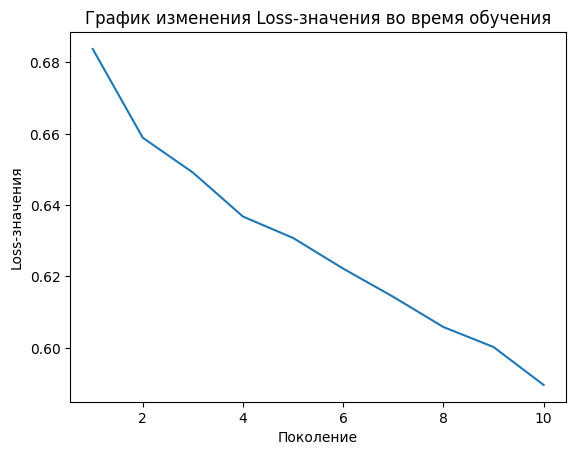

Точность на тестовом датасете: 0.622


In [ ]:
model = NeuralNetwork()
model.to(device)
optimization = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, train_data_loader, criterion, optimization, epochs_count, device)

test_accuracy = get_accuracy(model, test_data_loader, device)
print(f"Точность на тестовом датасете: {test_accuracy}")

# Аналогично инициализируем предобученную модель resnet18, дообучаем на нашем датасете и смотрим точность

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 337MB/s]


Прошло 1 поколение обучения, Loss-значение = 0.25449264806414407
Прошло 2 поколение обучения, Loss-значение = 0.09091890987659258
Прошло 3 поколение обучения, Loss-значение = 0.06623095019705712
Прошло 4 поколение обучения, Loss-значение = 0.050201700172490545
Прошло 5 поколение обучения, Loss-значение = 0.03461925658796515
Прошло 6 поколение обучения, Loss-значение = 0.028138321883503407
Прошло 7 поколение обучения, Loss-значение = 0.01907227622226827
Прошло 8 поколение обучения, Loss-значение = 0.01732414121931744
Прошло 9 поколение обучения, Loss-значение = 0.012422348838299513
Прошло 10 поколение обучения, Loss-значение = 0.011108446888448227


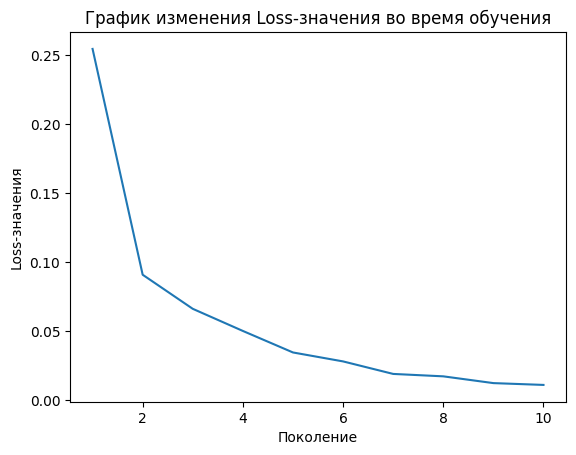

Точность предобученной модели resnet: 0.976


In [ ]:
pretrained_model = torchvision.models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 2)
pretrained_model.to(device)
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)
train_model(pretrained_model, train_data_loader, criterion, optimizer, epochs_count, device)

accuracy = get_accuracy(pretrained_model, test_data_loader, device)
print(f"Точность предобученной модели resnet: {accuracy}")
